In [1]:
%%capture --no-stderr
%pip install -U langgraph langsmith tavily-python langchain_tavily matplotlib langchain_experimental

In [2]:
# Set environment variables for tracing via LangSmith

import os

os.environ['LANGSMITH_TRACING'] = 'true'
os.environ['LANGSMITH_PROJECT'] = 'gb-researcher'

In [3]:
# Define tools

from langchain_tavily import TavilySearch
from langchain_core.tools import Tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearch(
    max_results=2,
    search_depth="basic",  # 搜索深度: "basic" 或 "advanced"
    include_answer=True,  # 包含AI生成的答案
    include_raw_content=False,  # 不包含原始HTML内容
    include_images=False  # 不包含图片链接
)

python_repl = PythonREPL()

repl_tool = Tool(
    name="python_repl",
    description="A Python shell. Use this to execute python commands. Input should be a valid python command. If you want to see the output of a value, you should print it out with `print(...)`.",
    func=python_repl.run,
)

In [4]:
# Auxiliary Functions

from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

def agent_node(state, agent, name):
    name = name.replace(' ', '_').replace('-', '_')

    result = agent.invoke(state)

    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.model_dump(exclude={'type', 'name'}), name=name)

    return {
        'messages': [result],
        'sender': name
    }

def create_agent(llm, tools, tool_message, custom_notice=''):

    prompt = ChatPromptTemplate.from_messages([
        (
            'system', 
            'You are a helpful assistant that can answer questions and perform tasks using Python code. You can also search the web for information. If you need to use a tool, you will be provided with the necessary details.'
            'If you have the final answer or deliverable, prefix your response with "FINAL ANSWER" so that the team knows to stop.'
            '\n{custom_notice}\n'
            'You have access to the following tools: {tool_names}.\n{tool_message}\n\n'
        ),
        MessagesPlaceholder(variable_name="messages"),
    ])

    prompt = prompt.partial(tool_message=tool_message, custom_notice=custom_notice, tool_names=', '.join([tool.name for tool in tools]))

    return prompt | llm.bind_tools(tools)

In [5]:
# Create llms for agents

from langchain_openai import ChatOpenAI

research_llm = ChatOpenAI(model='gpt-4o-mini')
chart_llm = ChatOpenAI(model='gpt-4o-mini')

In [6]:
# Research Agent

import functools

research_agent = create_agent(
    llm=research_llm,
    tools=[tavily_tool],
    tool_message=(
        'Before using search engines, please carefully think through and clarify the query, then conduct a single search that addresses all aspects for the query in one go.'
    ),
    custom_notice=(
        'Notice:\n'
        'Only gather and organize information. Do not generate code or give final conclusions, leave it to other assistants.'
    )
)

research_node = functools.partial(agent_node, agent=research_agent, name='Researcher')

In [7]:
# Table Agent

table_agent = create_agent(
    llm=chart_llm,
    tools=[repl_tool],
    tool_message=(
        'Create clear and well-formatted tables to display the provided data. Use pandas DataFrame and print() to show the table in a readable format.'
    ),
    custom_notice=(
        'Notice:\n'
        'If all tasks completed, respond with "FINAL ANSWER".'
    )
)

table_node = functools.partial(agent_node, agent=table_agent, name='Table')

In [8]:
# Tool call Agent

from langgraph.prebuilt import ToolNode

tools = [tavily_tool, repl_tool]

tool_node = ToolNode(tools=tools)

In [9]:
# Agent State

import operator
from typing import Annotated, Sequence, TypedDict
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str


In [10]:
# Create graph

from langgraph.graph import StateGraph

flow = StateGraph(AgentState)

flow.add_node('Researcher', research_node)
flow.add_node('Table', table_node)
flow.add_node('Tool', tool_node)

In [11]:
# Router

from typing import Literal
from langgraph.graph import START, END

def router(state) ->Literal['Researcher', 'Table', 'Tool']:
    messages = state['messages']
    last_message = messages[-1] if messages else None

    if last_message:
        if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
            return 'Tool'

        if hasattr(last_message, 'content') and 'FINAL ANSWER' in last_message.content:
            return END
        
    return 'continue'


flow.add_conditional_edges(
    'Researcher',
    router,
    {
        'continue': 'Table',
        'Tool': 'Tool',
        END: END
    }
)

flow.add_conditional_edges(
    'Table',
    router,
    {
        'continue': 'Researcher',
        'Tool': 'Tool',
        END: END
    }
)

flow.add_conditional_edges(
    'Tool',
    lambda x: x['sender'],
    {
        'Researcher': 'Researcher',
        'Table': 'Table'
    }
)

flow.add_edge(START, 'Researcher')

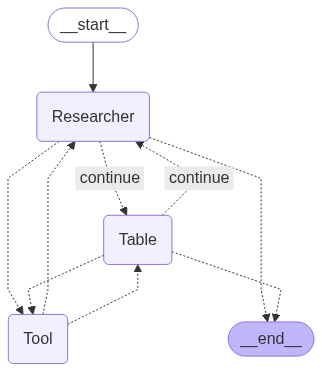

In [12]:
# Compile graph

from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display

checkpoint = MemorySaver()

graph = flow.compile(checkpointer=checkpoint)

try: 
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Error displaying graph: {e}")

In [13]:
# Execute MA workflow

from langchain_core.messages import HumanMessage
from uuid import uuid4

thread_id = str(uuid4())

config = {
    'configurable': {
        'thread_id': thread_id,
    },
    'recursion_limit': 10
}

events = graph.stream(
    input={
        'messages': [
            HumanMessage(
                'Obtain the GDP data of the United States from 2000 to 2020, and then create a table to display the GDP values by year.'
            )
        ]
    },
    config=config,
    stream_mode='values'
)

for event in events:
    if 'messages' in event:
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Obtain the GDP data of the United States from 2000 to 2020, and then create a table to display the GDP values by year.
================================== Ai Message ==================================
Name: Researcher
Tool Calls:
  tavily_search (call_9ollqg9ct1t4dWWdJija40CL)
 Call ID: call_9ollqg9ct1t4dWWdJija40CL
  Args:
    query: United States GDP data 2000 to 2020
    include_domains: ['worldbank.org', 'gov', 'imf.org']
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "United States GDP data 2000 to 2020", "follow_up_questions": null, "answer": "The U.S. GDP grew annually from 4.8% in 2000 to 1.6% in 2009, then recovered to 2.9% in 2020. The pandemic caused a sharp decline in 2020, with GDP decreasing by 3.5%.", "images": [], "results": [{"url": "https://data.worldbank.org/indicator/NY.GDP.MKTP.KD.ZG?locations=U

Python REPL can execute arbitrary code. Use with caution.


================================== Ai Message ==================================
Name: Table
Tool Calls:
  python_repl (call_TTjg9ITtoM4SDJEeC3jj2Ztx)
 Call ID: call_TTjg9ITtoM4SDJEeC3jj2Ztx
  Args:
    __arg1: import pandas as pd
data = {
    'Year': [2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020],
    'GDP (in Trillions)': [10.2, 10.5, 10.6, 10.9, 11.2, 11.7, 12.2, 13.0, 14.0, 14.4, 14.7, 15.0, 15.5, 16.2, 16.8, 17.5, 18.2, 18.7, 20.5, 21.0, 21.4]
}

gdp_df = pd.DataFrame(data)
print(gdp_df)
================================= Tool Message =================================
Name: python_repl

    Year  GDP (in Trillions)
0   2000                10.2
1   2001                10.5
2   2002                10.6
3   2003                10.9
4   2004                11.2
5   2005                11.7
6   2006                12.2
7   2007                13.0
8   2008                14.0
9   2009                14.4
10 